# Hyper-Heuristic based on Transformers for Solving Continuous Optimisation Problems

This work aims to integrate and explore the usage of Transformers in Hyper-Heuristic models to generate modified metaheuristics that solve continuous optimisation problems.

As a first stage of the exploration, all the experiments are executed on a single optimisation problem; the Sphere function with ten dimensions. 

Two approaches were studied:
- Use the transformers to classify metaheuristics into the available search operators.
- Use the transformers to generate text based on a sentence that comprises the metaheuristic.

The hyper-heuristic generates metaheuristics by selecting a set of search operators (simple heuristics) from a collection that contains 205 different operators.

These two approaches were explored using two different representations of a metaheuristic:
- The metaheuristic as the sequence of indices of the search operators.
  - For example, 66, 196
- The metaheuristic as the sequence of a plain description of the search operators.
  - For example, ('genetic_crossover', {'pairing': 'random', 'crossover': 'two', 'mating_pool_factor': 0.4}, 'all'), ('genetic_crossover', {'pairing': 'random', 'crossover': 'linear_0.5_0.5', 'mating_pool_factor': 0.4}, 'all')
- Or the metaheuristic as the sequence of compressed representation of the simple heuristics
  - For example, 'GC,r;two;0.4,d' and 'GC,r;l;0.4,d'

# Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

import operators as Operators
import benchmark_func as bf
from metaheuristic import Metaheuristic
from hyperheuristic import Hyperheuristic, _save_step
from neural_network import ModelPredictorTransformerOriginal, DatasetSequences, ModelPredictorKeras
from encode_operators import compress_operator, decompress_operator
from tools import read_json

from transformers import PreTrainedTokenizerFast, \
  AutoModelForSequenceClassification, AutoTokenizer, \
  TrainingArguments, Trainer, DataCollatorWithPadding, \
  GPT2LMHeadModel, AutoConfig, DataCollatorForLanguageModeling, \
    pipeline
from datasets import load_metric as load_metric_hf 
from datasets import Dataset as Dataset_hf

from timeit import default_timer as timer

HuggingfaceHub to support upload and download models

In [2]:
from huggingface_hub import notebook_login
# notebook_login()

# Collection of Search Operators

In [3]:
# Read operators and find their alias
collections = ['default.txt']
encoded_heuristic_space = dict()
operators_string = dict()
for collection_file in collections:
    with open('./collections/' + collection_file, 'r') as operators_file:
        operators_string[collection_file] = [line.rstrip('\n') for line in operators_file]
        encoded_heuristic_space[collection_file] = [eval(line) for line in operators_string[collection_file]]

In [4]:
encoded_heuristic_space['default.txt'][:3]

[('random_search', {'scale': 1.0, 'distribution': 'uniform'}, 'greedy'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'all'),
 ('central_force_dynamic',
  {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0},
  'greedy')]

In [5]:
operators_string['default.txt'][:3]

["('random_search', {'scale': 1.0, 'distribution': 'uniform'}, 'greedy')",
 "('central_force_dynamic', {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0}, 'all')",
 "('central_force_dynamic', {'gravity': 0.001, 'alpha': 0.01, 'beta': 1.5, 'dt': 1.0}, 'greedy')"]

# Generator of Metaheuristics

Use this function to generate metaheuristics given the machine learning model that have the 'predict' method.

In [6]:
def generate_metaheuristics(model, params, num_replicas=100, do_compression=False):
  problem = bf.Sphere(10)
  file_label = params['file_label']
  hh = Hyperheuristic(problem=problem.get_formatted_problem(),
                      heuristic_space='default.txt',
                      file_label=file_label)
  hh.parameters['num_agents'] = 30
  hh.parameters['num_steps'] = 100
  hh.parameters['stagnation_percentage'] = 0.5
  hh.parameters['verbose'] = True

  sequence_per_repetition = list()
  fitness_per_repetition = list()
  logs_time = []
  for rep in range(num_replicas):
      # Metaheuristic
      start_time = timer()
      mh = Metaheuristic(hh.problem, num_agents=hh.parameters['num_agents'], num_iterations=hh.num_iterations)

      # Initialiser
      mh.apply_initialiser()

      # Extract the population and fitness values, and their best values
      current_fitness = np.copy(mh.pop.global_best_fitness)
      current_position = np.copy(mh.pop.rescale_back(mh.pop.global_best_position))

      # Heuristic sets
      hh.current_space = np.arange(hh.num_operators)

      # Initialise additional variables
      candidate_enc_so = list()
      current_sequence = []

      best_fitness = [current_fitness]
      best_position = [current_position]

      step = 0
      stag_counter = 0
      exclude_indices = []
      normalize_weights = lambda w: w / sum(w) if sum(w) > 0 else np.ones(hh.num_operators) / hh.num_operators

      # Finalisator
      while not hh._check_finalisation(step, stag_counter):
          # Use the trained model to predict operators weights
          if stag_counter == 0:
              if len(current_sequence) == 0:
                  operator_prediction = np.array(np.ones(hh.num_operators))
              else:
                  if do_compression:
                    # Can be True if tokenizer handle compressed representation of search operators
                    compress_seq = [compress_operator(encoded_heuristic_space['default.txt'][op]) for op in current_sequence]
                    operator_prediction = model.predict(compress_seq)
                  else:
                    operator_prediction = model.predict(current_sequence)
              operators_weights = normalize_weights(operator_prediction)

          # Select a simple heuristic and apply it
          candidate_enc_so = hh._obtain_candidate_solution(sol=1, operators_weights=operators_weights)
          candidate_search_operator = hh.get_operators([candidate_enc_so[-1]])
          perturbators, selectors = Operators.process_operators(candidate_search_operator)

          mh.apply_search_operator(perturbators[0], selectors[0])

          # Extract population and fitness values
          current_fitness = np.copy(mh.pop.global_best_fitness)
          current_position = np.copy(mh.pop.rescale_back(mh.pop.global_best_position))

          # Print update
          if hh.parameters['verbose']:
              print(
                  '{} :: Transformer, Rep: {:3d}, Step: {:3d}, Trial: {:3d}, SO: {:30s}, currPerf: {:.2e}, candPerf: {:.2e}, '
                  'csl: {:3d}'.format(
                      hh.file_label, rep + 1, step + 1, stag_counter,
                      candidate_search_operator[0][0] + ' & ' + candidate_search_operator[0][2][:4],
                      best_fitness[-1], current_fitness, len(hh.current_space)), end=' ')

          # If the candidate solution is better or equal than the current best solution
          if current_fitness < best_fitness[-1]:
              # Update the current sequence and its characteristics
              current_sequence.append(candidate_enc_so[-1])

              best_fitness.append(current_fitness)
              best_position.append(current_position)

              # Update counters
              step += 1
              stag_counter = 0
              # Reset tabu list
              exclude_indices = []

              # Add improvement mark
              if hh.parameters['verbose']:
                  print('+', end='')

          else:  # Then try another search operator
              # Revert the modification to the population in the mh object
              mh.pop.revert_positions()

              # Update stagnation
              stag_counter += 1
              if stag_counter % 5 == 0:
                  # Include last search operator's index to the tabu list
                  exclude_indices.append(candidate_enc_so[-1])
                  operator_prediction[exclude_indices[-1]] = 0
                  operators_weights = normalize_weights(operator_prediction)

          # Add ending mark
          if hh.parameters['verbose']:
              print('')

      # Print the best one
      if hh.parameters['verbose']:
          print('\nBest fitness: {},\nBest position: {}'.format(current_fitness, current_position))

      # Update the repetition register
      sequence_per_repetition.append(np.double(current_sequence).astype(int).tolist())
      fitness_per_repetition.append(np.double(best_fitness).tolist())

      
      # Save this historical register
      _save_step(rep,
                  dict(encoded_solution=np.array(current_sequence),
                      best_fitness=np.double(best_fitness),
                      best_positions=np.double(best_position),
                      details=dict(
                          fitness_per_rep=fitness_per_repetition,
                          sequence_per_rep=sequence_per_repetition,
                      )),
                  hh.file_label)
      
      logs_time.append(timer() - start_time)
  df_times = pd.DataFrame({"time": logs_time})
  df_times.to_csv(f'./data_files/ml_models/{hh.file_label}_mhs_time_prediction_logs.csv')
  return sequence_per_repetition, fitness_per_repetition

# Generator of training data

Auxiliar functions to read, store, or generate metaheuristics for the training dataset. 

In [7]:
def read_stored_sequences(lim_pages=10):
  seqs, costs = [], []
  for counting in range(1, lim_pages + 1):
    with open(f'vocabulary/seq_read_{counting}.txt', 'r', encoding='utf-8') as file:
      seqs = seqs + file.read().split('\n')  
    with open(f'vocabulary/score_{counting}.txt', 'r', encoding='utf-8') as file:
      costs = costs + file.read().split('\n')
  return seqs, costs

def generate_training_dataset(num_samples=1000):
  params = {
    'file_label': 'Sphere-10D-default_nn_best_double_lstm',
    'num_steps': 100,
    'memory_length': 60,
    'num_operators': 205,
    'load_model': True,
    'save_model': False,
    'encoder': 'identity',
    'model_architecture': 'LSTM',
    'model_architecture_layers': [
      [20, 'sigmoid', 'LSTM'],
      [20, 'sigmoid', 'LSTM']
    ],
    'fitness_to_weight': 'rank',
  }
  model = ModelPredictorKeras(params)
  seqs, costs = generate_metaheuristics(model, params, num_samples)
  return seqs, costs

def store_sequences(seqs, costs, lim_sequences_per_page=100):
  counting = 0
  paths = []
  for i in range(0, len(seqs), lim_sequences_per_page):
    counting += 1
    with open(f'vocabulary/seq_read_{counting}.txt', 'w', encoding='utf-8') as file:
      file.write('\n'.join(seqs[i:i+lim_sequences_per_page]))
    with open(f'vocabulary/score_{counting}.txt', 'w', encoding='utf-8') as file:
      file.write('\n'.join([str(x) for x in costs[i:i+lim_sequences_per_page]]))
    paths.append(f'vocabulary/seq_read_{counting}.txt')

##### Uncomment those functions that would be useful on your case
# seqs, costs = generate_training_dataset(1000)
# store_sequences(seqs, costs, 100)
stored_seqs, stored_costs = read_stored_sequences()


## Process stored data

Auxiliar functions to process the stored data

In [8]:
def parse_sequence(seq):
  operators = []
  prev_idx = 0
  counting = 0
  for i, c in enumerate(seq):
    if c == '(':
      counting += 1
    if c == ')':
      counting -= 1
      if counting == 0:
        operators.append(seq[prev_idx:i+1])
        prev_idx = i + 3
  return operators

def get_ids_operators(operators):
  ids = []
  for operator in operators:
    ids_bool = np.array(operators_string['default.txt']) == operator
    ids.append(np.where(ids_bool)[0][0])
  return ids

def process_stored_data(seqs=stored_seqs, costs=stored_costs):
  seqs_operators = []
  seqs_ids = []
  for seq in seqs:
    operators = parse_sequence(seq)
    seq_ids = get_ids_operators(operators)
    seqs_operators.append(operators)
    seqs_ids.append(seq_ids)
  fitnesses = [eval(cost) for cost in costs]
  return seqs_operators, seqs_ids, fitnesses

seqs_operators, seqs_ids, fitnesses = process_stored_data()

In [9]:
len(seqs_operators)

1000

## Obtain best 20% subsequences

In [10]:
def obtain_subsequences(percentage=0.2):
  _, seqs_ids, fitnesses = process_stored_data()
  dataset_id = DatasetSequences(seqs_ids, fitnesses, fitness_to_weight='rank')
  seqs_operators, _, fitnesses = process_stored_data()
  seqs_compressed_op = [[compress_operator(eval(operator)) for operator in seq] for seq in seqs_operators]
  dataset_op = DatasetSequences(seqs_compressed_op, fitnesses, fitness_to_weight='rank')

  Xid, yid, _ = dataset_id.obtain_dataset()
  Xop, _, fit = dataset_op.obtain_dataset()

  all_seqs = list(zip(fit, Xop, Xid, yid))
  all_seqs.sort(reverse=True)
  return all_seqs[:int(len(all_seqs) * percentage)]

all_subsequences = obtain_subsequences(1.0)
train_subsequences = obtain_subsequences(0.2)
test_subsequences = obtain_subsequences(0.4)[:len(train_subsequences)]

# Split information 
def split_subsequences(subsequences):
  readable_seqs = []
  readable_full_seqs = []
  readable_id_seqs = []
  readable_next = []
  readable_fitness = []
  for fi, xop, xid, yid in subsequences:
    readable_seqs.append(' '.join(xop))
    readable_full_seqs.append(' '.join([str(decompress_operator(x)) for x in xop]))
    readable_id_seqs.append(' '.join([str(x) for x in xid]))
    readable_next.append(yid)
    readable_fitness.append(fi)
  return readable_seqs, readable_full_seqs, readable_id_seqs, readable_next, readable_fitness


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [11]:
readable_seqs, readable_full_seqs, readable_id_seqs, readable_next, readable_fitness = split_subsequences(train_subsequences)

In [12]:
test_readable_seqs, test_readable_full_seqs, test_readable_id_seqs, test_readable_next, test_readable_fitness = split_subsequences(test_subsequences)

# Train a tokenizer

Train a tokenizer for each possible case (pre-trained model / representation of the sequences) so the transformer model can have a better understanding of the given sequence

In [13]:
def train_tokenizer(tokenizer_label,
                    pretrained_tokenizer,
                    training_data):
  old_tokenizer = PreTrainedTokenizerFast.from_pretrained(pretrained_tokenizer)
  tokenizer = old_tokenizer.train_new_from_iterator(training_data, vocab_size=30522)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  tokenizer.save_pretrained('vocabulary/' + tokenizer_label)
  tokenizer.push_to_hub(tokenizer_label)
  return tokenizer

#bert_tokenizer = train_tokenizer('hybertheuristic-tokenizer', 'bert-base-uncased', readable_full_seqs)
#bert_tokenizer_ids = train_tokenizer('HyBert-tokenizer-ids', 'distilbert-base-uncased', readable_id_seqs)
#bert_tokenizer_compressed = train_tokenizer('HyBert-tokenizer-compress', 'bert-base-uncased', readable_seqs)

#gpt_tokenizer_ids = train_tokenizer('HyGpt-tokenizer-ids', 'gpt2', readable_id_seqs)
#gpt_tokenizer_compressed = train_tokenizer('HyGpt-tokenizer-compress', 'gpt2', readable_seqs)

# Experiments

## Pre-process training dataset

Auxiliar functions to pre-process plain-text to give to transformer models

In [14]:
def prepare_dataset_for_classification(tokenizer, data, max_length, labels=readable_next):
  ds_dict = Dataset_hf.from_dict({
    'text': data,
    'label': labels
  })
  train_dataset = ds_dict.map(lambda w: tokenizer(w['text'], 
                                                  truncation=True, 
                                                  max_length=max_length),
                              batched=True)
  train_dataset.set_format(type='torch', columns=['input_ids',
                                                  'label',
                                                  'attention_mask'])
  return train_dataset

In [15]:
def prepare_training_dataset_for_CLM(tokenizer, max_length):
  seqs_operators, _, _ = process_stored_data()
  seqs_compressed_op = [[compress_operator(eval(operator)) for operator in seq] for seq in seqs_operators]
  seqs_str = [' '.join(a) for a in seqs_compressed_op]

  ds_dict = Dataset_hf.from_dict({
    'content': seqs_str,
  })

  train_dataset = ds_dict.map(lambda w: tokenizer(w['content'], 
                                                  truncation=True,
                                                  max_length=max_length,
                                                  return_length=True),
                              batched=True)

  input_batch = []
  for length, input_ids in zip(train_dataset["length"], train_dataset["input_ids"]):
      if length == max_length:
          input_batch.append(input_ids)
  ds_train = Dataset_hf.from_dict({"input_ids": input_batch})
  return ds_train

## Classification

### General parameters

In [16]:
params = {
    'file_label': '',
    'pretrained_tokenizer' : '',
    'pretrained_model': '',
    'num_steps': 100,
    'num_operators': 205,
    'load_model': True,
    'save_model': False,
    'encoder': 'identity',
    'epochs': 1,
    'model_architecture': 'transformer_orig',
    'fitness_to_weight': 'rank',
  }

In [17]:
def train_models(train_dataset,
                 file_label,
                 tokenizer_label,
                 pretrained_model, 
                 epochs):
  # Setting missing parameters
  params['file_label'] = file_label
  params['pretrained_tokenizer'] = tokenizer_label
  params['pretrained_model'] = pretrained_model
  model = ModelPredictorTransformerOriginal(params)
  
  # Metric
  metric = load_metric_hf("accuracy")
  def compute_metrics(eval_pred):
      logits, labels = eval_pred
      predictions = np.argmax(logits, axis=-1)
      return metric.compute(predictions=predictions, references=labels)

  # Training
  for epoch in range(epochs):
    batch_size = 32
    if epoch > 0:
        model._model = AutoModelForSequenceClassification.from_pretrained(f'{file_label}/model-{epoch-1}')
    training_args = TrainingArguments(
        output_dir=f'{file_label}/train-{epoch}',
        logging_dir=f'{file_label}/train-{epoch}',
        evaluation_strategy='epoch',
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        eval_steps=1,
        num_train_epochs=1, 
        weight_decay=0.01,
        logging_steps = 1,
        disable_tqdm=False)
    
    data_collator = DataCollatorWithPadding(tokenizer=model._tokenizer, padding=True)
    model._trainer = Trainer(
        model=model._model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=train_dataset,
        tokenizer=model._tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    
    # Fit model
    model._trainer.train()

    # Save predict function        
    model._predict = model._trainer.predict
    model._trainer.save_model(f'{file_label}/model-{epoch}')
    model._model.push_to_hub(f'{file_label}-model-{epoch}')
  return model

### Ids

In [18]:
args_train = [
  {
    'pretrained_model': 'distilbert-base-uncased',
    'trained_tokenizer': 'HyBert-tokenizer-ids',
    'max_length': 512,
    'file_label': 'HyBertHeuristic'
  },
  {
    'pretrained_model': 'gpt2',
    'trained_tokenizer': 'HyGpt-tokenizer-ids',
    'max_length': 1024,
    'file_label': 'HyGpt2'
  },  
]
def train_models_based_on_ids(epochs):
  models = []
  for args_model in args_train:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_label)
    ids_train = \
      prepare_dataset_for_classification(tokenizer, 
                                        readable_id_seqs, 
                                        args_model['max_length'])
    
    model = train_models(ids_train,
                args_model['file_label'],
                tokenizer_label,
                args_model['pretrained_model'],
                epochs=epochs)
    models.append(model)
  return models

# Uncomment to train models
#models = train_models_based_on_ids(10)

In [19]:
def produce_metaheuristics_from_trained_model(epochs):
  results = []
  for args_model in args_train:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
    params['pretrained_tokenizer'] = tokenizer_label
    for epoch in range(epochs):
      file_label = 'Sphere-10D-'+f'{args_model["file_label"]}-model-{epoch}'
      params['file_label'] = file_label
      params['pretrained_model'] = 'josetapia/'+f'{args_model["file_label"]}-model-{epoch}'
      model = ModelPredictorTransformerOriginal(params)    
      seqs_model, costs_model = generate_metaheuristics(model, params)
      results.append((seqs_model, costs_model))
  return results

# Uncomment to produce metaheuristics
#results = produce_metaheuristics_from_trained_model(10)


In [20]:
def evaluate_trained_model(epochs):
  for args_model in args_train[:1]:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
  params['pretrained_tokenizer'] = tokenizer_label
  
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_label)
  ids_test = \
    prepare_dataset_for_classification(tokenizer, 
                                      test_readable_id_seqs, 
                                      args_model['max_length'],
                                      test_readable_next)
    
  for epoch in range(epochs):
    file_label = 'Sphere-10D-'+f'{args_model["file_label"]}-model-{epoch}'
    params['file_label'] = file_label
    params['pretrained_model'] = 'josetapia/'+f'{args_model["file_label"]}-model-{epoch}'
    model = ModelPredictorTransformerOriginal(params)    
    outputs = model._predict(ids_test)
    print(args_model["file_label"], epoch, outputs.metrics['test_accuracy'])

# Uncomment to evaluate the models
#evaluate_trained_model(10)

### Compressed Representation

In [21]:
args_train_compress = [
  {
    'pretrained_model': 'bert-base-uncased',
    'trained_tokenizer': 'HyBert-tokenizer-compress',
    'max_length': 512,
    'file_label': 'HyBertHeuristic_compressed'
  },
  {
    'pretrained_model': 'gpt2',
    'trained_tokenizer': 'HyGpt-tokenizer-compress',
    'max_length': 1024,
    'file_label': 'HyGpt2_compressed'
  },  
]
def train_models_based_on_compressed_id(epochs=10):
  models = []
  for args_model in args_train_compress:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_label)
    ids_train = \
      prepare_dataset_for_classification(tokenizer, 
                                        readable_seqs, 
                                        args_model['max_length'])
    
    model = train_models(ids_train,
                args_model['file_label'],
                tokenizer_label,
                args_model['pretrained_model'],
                epochs=epochs)
    models.append(model)
  return models

#models = train_models_based_on_compressed_id()

In [22]:
def produce_metaheuristics_from_trained_model_compress(epochs):
  results_compress = []
  for args_model in args_train_compress:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
    params['pretrained_tokenizer'] = tokenizer_label
    for epoch in range(epochs):
      file_label = 'Sphere-10D-'+f'{args_model["file_label"]}-model-{epoch}'
      params['file_label'] = file_label
      params['pretrained_model'] = 'josetapia/'+f'{args_model["file_label"]}-model-{epoch}'
      model = ModelPredictorTransformerOriginal(params)    
      seqs_model, costs_model = generate_metaheuristics(model, params)
      results_compress.append((seqs_model, costs_model))
  return results_compress

#results_compress = produce_metaheuristics_from_trained_model_compress()

In [23]:
def evaluate_trained_model_compress(epochs):
  for args_model in args_train_compress[:1]:
    tokenizer_label = 'josetapia/' + args_model['trained_tokenizer']
  params['pretrained_tokenizer'] = tokenizer_label
  
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_label)
  ids_test = \
    prepare_dataset_for_classification(tokenizer, 
                                      test_readable_seqs, 
                                      args_model['max_length'],
                                      test_readable_next)
    
  for epoch in range(epochs):
    file_label = 'Sphere-10D-'+f'{args_model["file_label"]}-model-{epoch}'
    params['file_label'] = file_label
    params['pretrained_model'] = 'josetapia/'+f'{args_model["file_label"]}-model-{epoch}'
    model = ModelPredictorTransformerOriginal(params)    
    outputs = model._predict(ids_test)
    print(args_model["file_label"], epoch, outputs.metrics['test_accuracy'])

# Uncomment to evaluate the models
#evaluate_trained_model_compress(10)

## Casual Language Model

In [24]:
def train_from_scratch(tokenizer_label, context_length=1024):
  # Tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_label)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  # Dataset  
  ds_train = prepare_training_dataset_for_CLM(tokenizer, context_length)

  # Model's arguments
  config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
  )
  model = GPT2LMHeadModel(config)
  data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

  args = TrainingArguments(
      output_dir="hygpt2-clm",
      per_device_train_batch_size=32,
      per_device_eval_batch_size=32,
      evaluation_strategy="steps",
      eval_steps=5_000,
      logging_steps=5_000,
      gradient_accumulation_steps=8,
      num_train_epochs=1,
      weight_decay=0.1,
      warmup_steps=1_000,
      lr_scheduler_type="cosine",
      learning_rate=5e-4,
      save_steps=5_000,
      #fp16=True,
      disable_tqdm=False,
      push_to_hub=True,
  )
      
  trainer = Trainer(
      model=model,
      tokenizer=tokenizer,
      args=args,
      data_collator=data_collator,
      train_dataset=ds_train,
      eval_dataset=ds_train,
  )
  trainer.train()
  trainer.save_model('HyGpt/hygpt-compress-clm')
  trainer.push_to_hub('hygpt-compress-clm')
  return trainer

# Uncomment to train a CLM model
#model = train_from_scratch('josetapia/' + 'HyGpt-tokenizer-compress', 1024)

In [33]:
# Generate data
seqs_compressed_op = [[compress_operator(eval(operator)) for operator in seq] for seq in seqs_operators]

# Fetch trained model
local = True
pipe = pipeline(
    "text-generation", model= 'transformer_models/hygpt2-cml' if local else "josetapia/hygpt2-cml-gen", max_length=1024
)

Example of usage

In [34]:
txt = 'GC,r;l;0.4,g_____________ GS,1.0;0.02,p____________ GC,t;b;0.4,g_____________ GC,t;b;0.4,d_____________ GC,t;b;0.4,g_____________ GC,t;two;0.4,m___________ GC,t;b;0.4,d_____________ RS,0.01;u,p______________ RW,0.75;1.0;u,d__________ PS,1.0;2.54;2.56;c;g,g___ RS,0.01;levy,g___________ GC,t;u;0.4,g_____________ GC,t;u;0.4,g_____________ GC,r;u;0.4,m_____________ GC,t;s;0.4,m_____________ GC,r;b;0.4,p_____________ GC,r;two;0.4,p___________ SD,0.9;22.5;0.1,p________ GC,cost;u;0.4,d__________ GC,t;two;0.4,p___________ DM,rtbc;1;1.0,p__________ GC,t;b;0.4,g_____________ SD,0.9;22.5;0.1,p________ DM,best;1;1.0,d__________ DM,rtb;1;1.0,g___________ GC,r;l;0.4,m_____________ GC,r;l;0.4,m_____________ GC,cost;b;0.4,p__________ RW,0.75;1.0;u,m__________ DM,best;1;1.0,p__________'
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

GC,r;l;0.4,g_____________ GS,1.0;0.02,p____________ GC,t;b;0.4,g_____________ GC,t;b;0.4,d_____________ GC,t;b;0.4,g_____________ GC,t;two;0.4,m___________ GC,t;b;0.4,d_____________ RS,0.01;u,p______________ RW,0.75;1.0;u,d__________ PS,1.0;2.54;2.56;c;g,g___ RS,0.01;levy,g___________ GC,t;u;0.4,g_____________ GC,t;u;0.4,g_____________ GC,r;u;0.4,m_____________ GC,t;s;0.4,m_____________ GC,r;b;0.4,p_____________ GC,r;two;0.4,p___________ SD,0.9;22.5;0.1,p________ GC,cost;u;0.4,d__________ GC,t;two;0.4,p___________ DM,rtbc;1;1.0,p__________ GC,t;b;0.4,g_____________ SD,0.9;22.5;0.1,p________ DM,best;1;1.0,d__________ DM,rtb;1;1.0,g___________ GC,r;l;0.4,m_____________ GC,r;l;0.4,m_____________ GC,cost;b;0.4,p__________ RW,0.75;1.0;u,m__________ DM,best;1;1.0,p__________ GC,p GC,p GC,t;1.4,d DM,m RF,r;,p GC,p RW,d GC,t;g GC,d DM,g,0.4,r;1.0;0.56;0.75;0;1;1;2.4,m RW,m RF,p GC,r;u;1;l;u;0.4,g,best;0,r;b;b;2.5;0.4,t;0.4,0.0.4,p RS,1;2.0.4,1.0;0.4,p PS,t;b;1;u;0;b;2.4,r;0.4,r;1.4,g,g DM,0.5,

# Results

Process data

In [35]:
exp_names = ["HyBertHeuristic-model-"+str(case) for case in range(20)] + \
  ['HyGpt-model-'+str(case) for case in range(10)] + \
    ['HyGpt-compress-tests']

In [36]:
fitness_good = []
last_fitness = lambda seqs: [seq[-1] for seq in seqs]

for exp_name in exp_names:
  A = read_json('transformer_experiments/'+exp_name+'.json')
  z = last_fitness(A['results'][0]['hist_fitness'])
  fitness_good.append(z)

In [37]:
def compute_fitness(seq):
  return np.median(seq) + st.iqr(seq)

In [38]:
last_fitness = [x[-1] for x in fitnesses[:100]]
compute_fitness(last_fitness)

0.08057391128452633

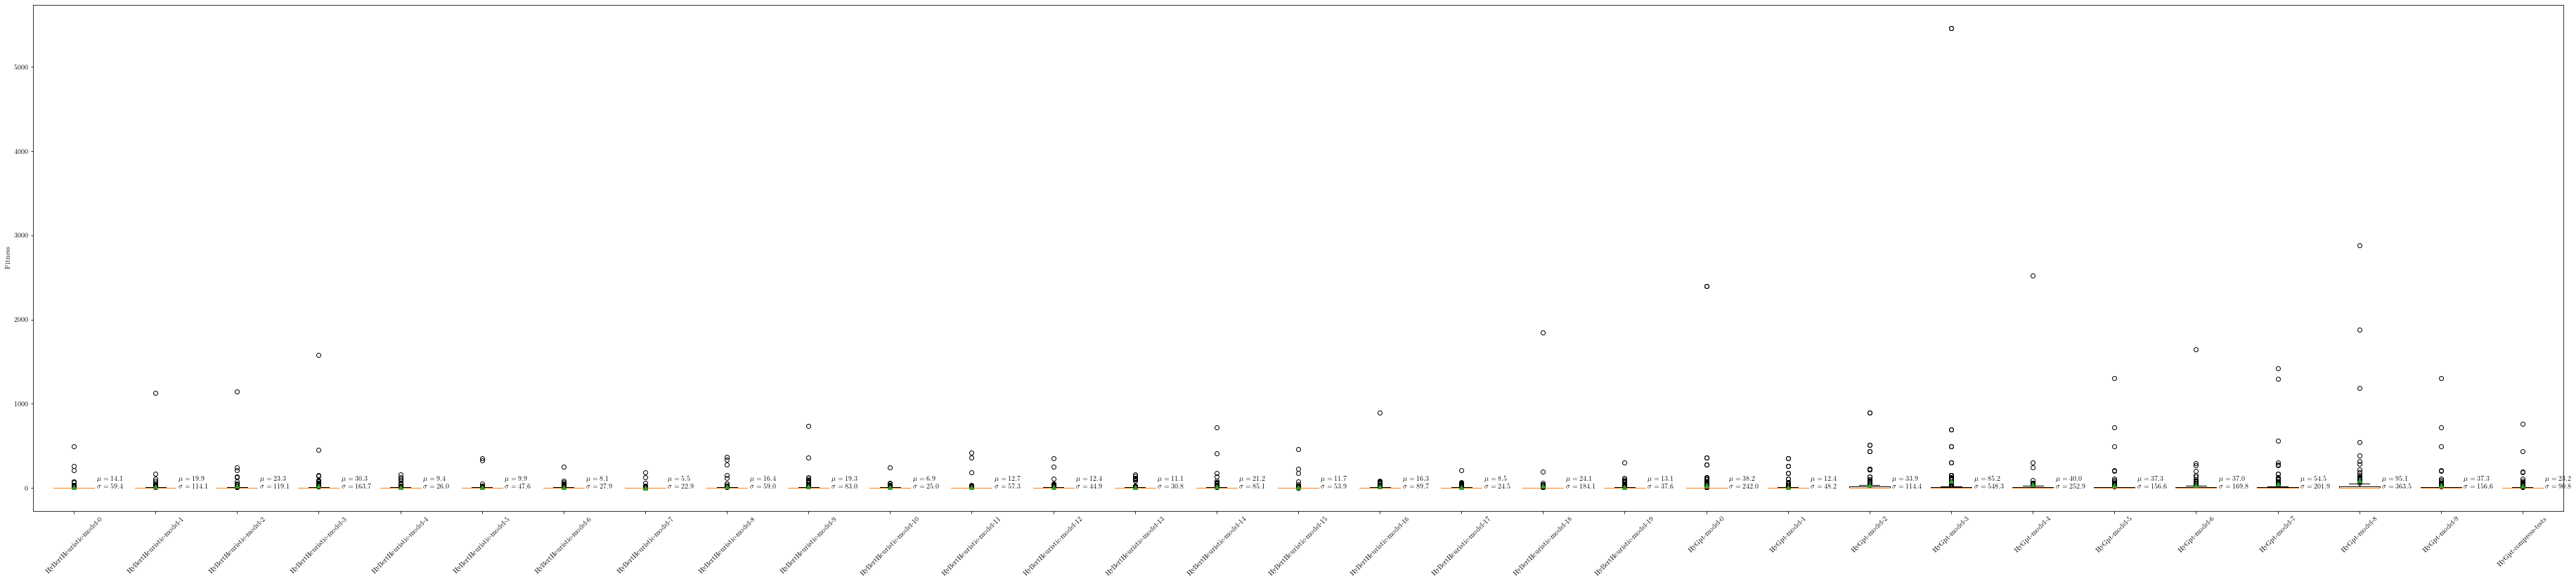

In [39]:
seqs_operators, seqs_ids, fitnesses = process_stored_data()
fig = plt.figure(figsize =(50, 10))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
def last_fitness(seqs):
  return [x[-1] for x in seqs] 
 
data = fitness_good 

# Creating plot
bp = ax.boxplot(data, showmeans=True)
m1 = [np.mean(x) for x in data]
med1 = [np.median(x) for x in data]
st1 = [np.std(x) for x in data]

for i, line in enumerate(bp['medians']):
  x, y = line.get_xydata()[1]
  
  text = '\n'.join((
  r'$\mu=%.1f$' % (m1[i], ),
  r'$\sigma=%.1f$' % (st1[i], )))
  ax.annotate(text, xy=(x+0.03, y-2.95))
ax.set_xticklabels(exp_names)
fig.subplots_adjust()
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

fig.tight_layout()
plt.ylabel('Fitness')
# show plot
figures_folder = 'transformer_experiments/'
saving_format = 'png'
fig.savefig(figures_folder + 'results_box_plots.' + saving_format, 
                    format=saving_format, bbox_inches="tight", dpi=333, transparent=True)
plt.show()

In [40]:
A, B, C = [], [], []
for x, y in zip(fitness_good, exp_names):
  z = compute_fitness(x)
  if 'HyBertHeuristic' in y:
    A.append(z)
  elif 'HyGpt-m' in y:
    B.append(z)
  else:
    C.append(z)

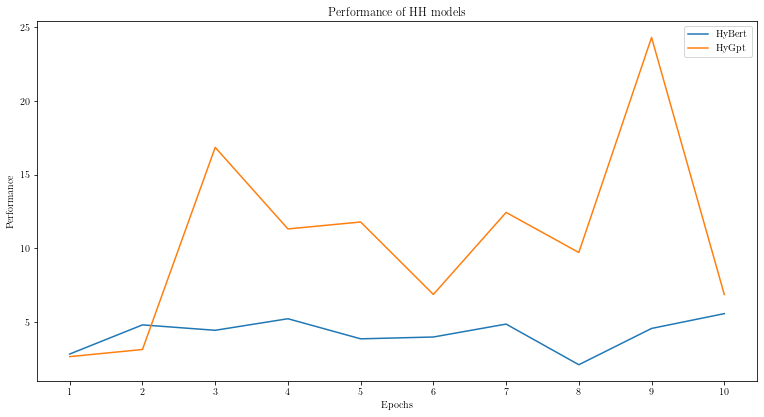

In [41]:
fi1 = plt.figure(figsize=(10, 5))
ax = fi1.add_axes([0, 0, 1, 1])

plt.plot(A[:10], label='HyBert')
plt.plot(B, label='HyGpt')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Performance of HH models')

ax.set_xticks(range(10))
ax.set_xticklabels([str(x) for x in range(1, 11)])

plt.rc('font', size=18)     
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['axes.titlesize'] = 21

plt.savefig(figures_folder + f'comparison_exps.' + saving_format,
            format=saving_format,bbox_inches = 'tight', dpi=333, transparent=True)
plt.show()
